\begin{center}
\textbf{Authors} \\
Mattia Zanin - \href{mailto:mattia.zanin@studenti.unipd.it}{\texttt{mattia.zanin@studenti.unipd.it}} \\
Matteo Giorgi - \href{mailto:matteo.giorgi.1@tudenti.unipd.it}{\texttt{matteo.giorgi.1@tudenti.unipd.it}} \\
Enrico Zanello - \href{mailto:enrico.zanello@studenti.unipd.it}{\texttt{enrico.zanello@studenti.unipd.it}} \\
Luca Lo Buono - \href{mailto:luca.lobuono@studenti.unipd.it}{\texttt{luca.lobuono@studenti.unipd.it}}

\vspace{1cm}
\end{center}

## Train/Test split (time-ordered)

We evaluate forecasting performance out-of-sample using a time-ordered split.
The last `H` observations are kept as test set, while the remaining observations are used for training.
This mirrors the real forecasting setting where future data are not available at estimation time.


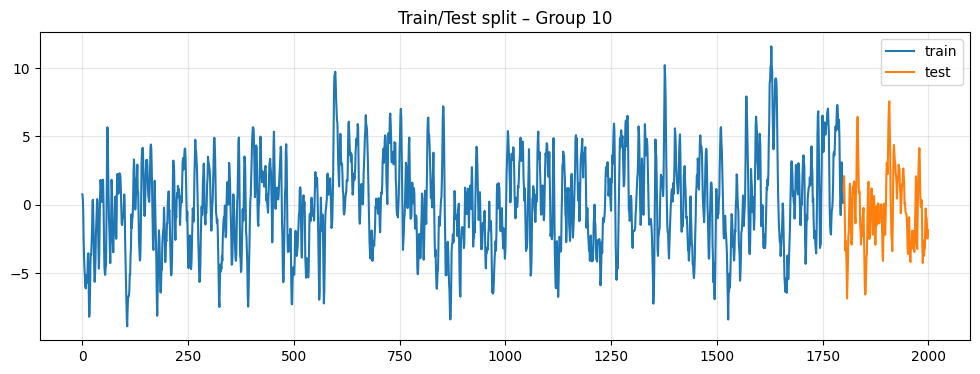

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("arma12_seasonal_controlled_15series.csv")
y = df["series_10"].astype(float).to_numpy()

H = 200  # test horizon (typical choice: 100-300 depending on length)
y_train, y_test = y[:-H], y[-H:]

plt.figure(figsize=(12, 4))
plt.plot(y_train, label="train")
plt.plot(np.arange(len(y_train), len(y)), y_test, label="test")
plt.title("Train/Test split – Group 10")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## Model fitting

Following the Box–Jenkins identification performed in the previous assignment, we fit the selected ARMA(p,q) model on the training set.


In [2]:
from statsmodels.tsa.arima.model import ARIMA

# ARMA(1,2) = ARIMA(1,0,2)
fit = ARIMA(y_train, order=(1, 0, 2), trend="n").fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1800
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2536.299
Date:                Tue, 16 Dec 2025   AIC                           5080.598
Time:                        10:28:11   BIC                           5102.580
Sample:                             0   HQIC                          5088.713
                               - 1800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7972      0.017     47.577      0.000       0.764       0.830
ma.L1          0.7062      0.022     31.449      0.000       0.662       0.750
ma.L2          0.5113      0.022     23.595      0.0

## Point forecasts and accuracy

We produce H-step-ahead forecasts for the test period and evaluate accuracy using standard loss functions (MAE and RMSE).


MAE: 2.10458178927103
RMSE: 2.637130596618867


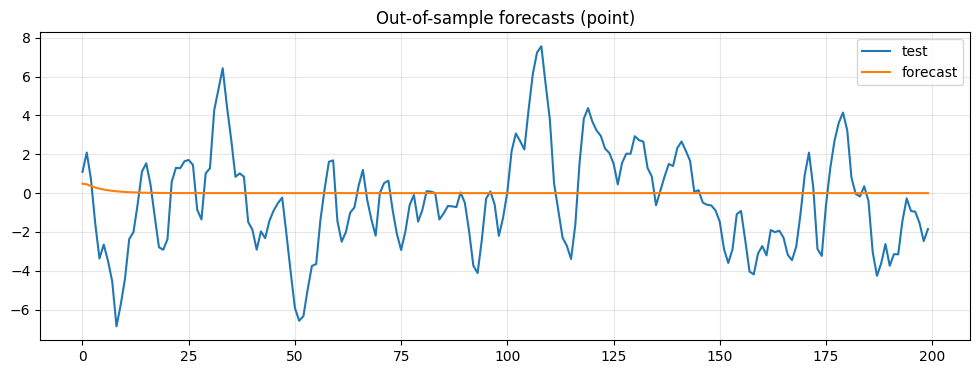

In [3]:
pred = fit.get_forecast(steps=H)
y_hat = pred.predicted_mean

mae = np.mean(np.abs(y_test - y_hat))
rmse = np.sqrt(np.mean((y_test - y_hat) ** 2))
print("MAE:", mae)
print("RMSE:", rmse)

plt.figure(figsize=(12, 4))
plt.plot(y_test, label="test")
plt.plot(y_hat, label="forecast")
plt.title("Out-of-sample forecasts (point)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### Rolling 1-step (se richiesto / consigliato)

In [4]:
from statsmodels.tsa.arima.model import ARIMA

history = list(y_train)
roll_forecasts = []

for t in range(H):
    m = ARIMA(history, order=(1, 0, 2), trend="n").fit()
    roll_forecasts.append(m.forecast(steps=1)[0])
    history.append(y_test[t])

roll_forecasts = np.array(roll_forecasts)

mae_r = np.mean(np.abs(y_test - roll_forecasts))
rmse_r = np.sqrt(np.mean((y_test - roll_forecasts) ** 2))
print("Rolling MAE:", mae_r)
print("Rolling RMSE:", rmse_r)

Rolling MAE: 0.8045793501230344
Rolling RMSE: 1.0131027773912855


## Interval forecasts

We compute 95% prediction intervals. In a correct ARMA specification, most test observations should fall within these bands, and the interval width reflects forecast uncertainty increasing with the horizon.


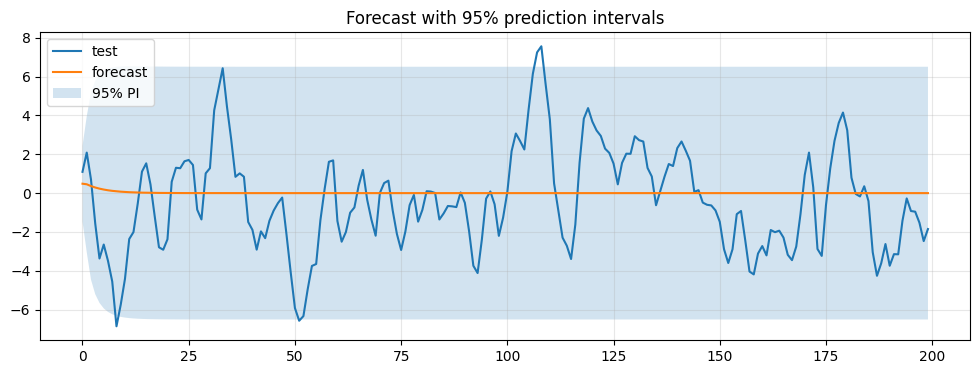

Empirical coverage: 0.98


In [5]:
ci = pred.conf_int(alpha=0.05)  # 95%
lower = ci[:, 0]
upper = ci[:, 1]

plt.figure(figsize=(12, 4))
plt.plot(y_test, label="test")
plt.plot(y_hat, label="forecast")
plt.fill_between(np.arange(H), lower, upper, alpha=0.2, label="95% PI")
plt.title("Forecast with 95% prediction intervals")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

coverage = np.mean((y_test >= lower) & (y_test <= upper))
print("Empirical coverage:", coverage)

## Benchmark comparison

We compare ARMA forecasts against a simple naive benchmark: $\hat{y}_{t+1}=y_t$.
Despite its simplicity, the naive model is often hard to beat in short-horizon forecasting.


In [6]:
naive = np.r_[y_train[-1], y_test[:-1]]  # forecast at t uses previous observed value
mae_n = np.mean(np.abs(y_test - naive))
rmse_n = np.sqrt(np.mean((y_test - naive) ** 2))
print("Naive MAE:", mae_n)
print("Naive RMSE:", rmse_n)

Naive MAE: 1.015481502653484
Naive RMSE: 1.2632077429018165


\bibliographystyle{alpha}
\bibliography{references}